Here is the library of functions:

In [10]:
def logistic(x):
    '''
    '''
    return 1/(1+np.exp(-x))

def U_logistic(theta, Y, X, phi):
    '''
    '''
    return - (Y.T @ X @ theta - np.sum(np.log(1+np.exp(X @ theta))) - 0.5 * phi * np.sum(theta**2))

def gradU_logistic(theta, Y, X, phi):
    '''
    '''
    n = X.shape[0]
    
    Y_pred = logistic(X @ theta)
    epsilon = (Y[:,np.newaxis] - Y_pred[:,np.newaxis])
    grad = X.T @ epsilon - phi * theta[:, np.newaxis]

    return -grad/n


def hmc(Y, X, U, gradU, M, eps, m, theta0, phi):
    '''
    '''
    theta = theta0.copy()
    n, p = X.shape
    
    # Precompute
    Minv = np.linalg.inv(M)
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]
    
    # Intial energy
    H0 = U(theta0, Y, X, phi) + 0.5 * np.asscalar(r.T @ Minv @ r)
    
    # Hamiltonian dynamics
    r -= (eps/2)*gradU(theta, Y, X, phi)
    for i in range(m):
        theta += (eps*Minv@r).ravel()
        r -= eps*gradU(theta, Y, X, phi)
    r -= (eps/2)*gradU(theta, Y, X, phi)
    
    # Final energy
    H1 = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r)
    
    # MH step
    u = np.random.uniform()
    rho = np.exp(H0 - H1) # Acceptance probability
    
    if u < np.min((1, rho)):
        # accept
        accept = True
        H = H1
    else:
        # reject
        theta = theta0
        accept = False
        H = H0

    return theta, accept, rho, H


def run_hmc(Y, X, U, gradU, M, eps, m, theta, phi, nsample):

    n, p = X.shape
    
    # Allocate space
    samples = np.zeros((nsample, p))
    accept = np.zeros(nsample)
    rho = np.zeros(nsample)
    H = np.zeros(nsample)
    
    # Run hmc
    for i in range(nsample):
        theta, accept[i], rho[i], H[i] = hmc(Y, X, U, gradU, M, eps, m, theta, phi)
        samples[i] = theta
        
    return samples, accept, rho, H  

def stogradU(theta, Y, X, nbatch, phi):
    '''A function that returns the stochastic gradient. Adapted from Eq. 5.
    Inputs are:
        theta, the parameters
        Y, the response
        X, the covariates
        nbatch, the number of samples to take from the full data
    '''
    n, p = X.shape
    
    # Sample minibatch
    batch_id = np.random.choice(np.arange(n),nbatch,replace=False)
    
    Y_pred = logistic(X[batch_id,:] @ theta[:,np.newaxis])
    epsilon = (Y[batch_id,np.newaxis] - Y_pred)
    grad = n/nbatch * X[batch_id,:].T @ epsilon - phi * theta[:, np.newaxis]

    #return -grad/n
    return -grad

def sghmc(Y, X, U, gradU, M, Minv, eps, m, theta, B, D, phi):
    
    n, p = X.shape
    
    # Randomly sample momentum
    r = np.random.multivariate_normal(np.zeros(p),M)[:,np.newaxis]
    
    # Hamiltonian dynamics
    for i in range(m):        
        theta += (eps*Minv@r).ravel()
        r -= eps*stogradU(theta, Y, X, nbatch,phi) - eps*C @ Minv @ r \
            + np.random.multivariate_normal(np.zeros(p),D)[:,np.newaxis] 
    
    # Record the energy
    H = U(theta, Y, X, phi) + np.asscalar(0.5 * r.T @ Minv @ r)
    
    return theta, H

def run_sghmc(Y, X, U, gradU, M, eps, m, theta, C, V, phi, nsample):
    n, p = X.shape
    
    # Precompute
    Minv = np.linalg.inv(M)
    B = 0.5 * V * eps
    D = 2*(C-B)*eps
    
    # Allocate space
    samples = np.zeros((nsample, p))
    H = np.zeros(nsample)
    
    # Run sghmc
    for i in range(nsample):
        theta, H[i] = sghmc(Y, X, U, gradU, M, Minv, eps, m, theta, B, D, phi)
        samples[i] = theta
        
    return samples, H
    
    
def gd(Y, X, gradU, eps, m, theta, phi):
    '''
    '''
    samples = np.zeros((nsample, p))
    
    for i in range(m):
        theta -= eps*gradU(theta, Y, X, phi).ravel()
      
    return theta     

In [1]:
import os
if not os.path.exists('./eigen'):
    ! git clone https://github.com/RLovelett/eigen.git

Cloning into 'eigen'...
remote: Counting objects: 89103, done.
remote: Total 89103 (delta 0), reused 0 (delta 0), pack-reused 89103
Receiving objects: 100% (89103/89103), 72.17 MiB | 28.15 MiB/s, done.
Resolving deltas: 100% (65927/65927), done.
Checking connectivity... done.


In [1]:
import cppimport
import numpy as np

In [41]:
%%file wrap.cpp
<%
cfg['compiler_args'] = ['-std=c++11']
cfg['include_dirs'] = ['./eigen']
setup_pybind11(cfg)
%>

#include <pybind11/pybind11.h>
#include <pybind11/numpy.h>
#include <pybind11/eigen.h>
#include <Eigen/Cholesky>

#include <random>
#include <algorithm>
#include <iterator>
#include <iostream>

namespace py = pybind11;

Eigen::VectorXd logistic(Eigen::VectorXd x) {
    return 1.0/(1.0 + exp((-x).array()));
}

Eigen::VectorXd gd(Eigen::MatrixXd X, Eigen::VectorXd y, Eigen::VectorXd beta, double alpha, int niter) {
    int n = X.rows();
    
    Eigen::VectorXd y_pred;
    Eigen::VectorXd resid;
    Eigen::VectorXd grad;
    Eigen::MatrixXd Xt = X.transpose();
            
    for (int i=0; i<niter; i++) {
        y_pred = logistic(X * beta);
        resid = y - y_pred;
        grad = Xt * resid / n;
        beta = beta + alpha * grad;
    }
    return beta;
}
   
Eigen::MatrixXd mvnorm(Eigen::VectorXd mu, Eigen::MatrixXd Sigma, int n) {
    std::default_random_engine gen;
    std::normal_distribution<double> distribution(0, 1);    
    
    Eigen::MatrixXd A(Sigma.llt().matrixL());
    int p = mu.size();
    Eigen::MatrixXd Z(n,p);  
            
    for(int i=0; i<n; i++) {
        Eigen::VectorXd v(p);
        for(int j=0; j<p; j++){
            v[j] = distribution(gen);
        }
        Z.row(i) = mu + A*v;
    }
    return Z;          
}
    
Eigen::VectorXd stogradU_logistic(Eigen::VectorXd theta, Eigen::VectorXd Y, Eigen::MatrixXd X, int nbatch, double phi) {
    // currently this does no random sampling
    int n = X.rows();            
                
    Eigen::VectorXd Y_pred;
    Eigen::VectorXd epsilon;
    Eigen::VectorXd grad;
    Eigen::MatrixXd Xt = X.transpose();            
                
    Y_pred = logistic(X * theta);
    epsilon = Y - Y_pred;
    grad = n/nbatch * Xt * epsilon - phi * theta;

    return -grad;
} 

Eigen::VectorXd sghmc_opt_run(Eigen::VectorXd Y, Eigen::MatrixXd X, Eigen::MatrixXd M, double eps, int m, Eigen::VectorXd theta, Eigen::MatrixXd C, Eigen::MatrixXd V, double phi, int nsample) {
    int n = X.rows();
    int p = X.cols();  
            
            
    /*
    n, p = X.shape
    
    # Precompute
    Minv = np.linalg.inv(M)
    B = 0.5 * V * eps
    D = 2*(C-B)*eps
    
    # Allocate space
    samples = np.zeros((nsample, p))
    H = np.zeros(nsample)
    
    # Run sghmc
    for i in range(nsample):
        theta, H[i] = sghmc(Y, X, U, gradU, M, Minv, eps, m, theta, B, D, phi)
        samples[i] = theta
        
    return samples, H
            
    */
    
    return Y;      
}
        
Eigen::VectorXd sghmc_opt(Eigen::VectorXd Y, Eigen::MatrixXd X, Eigen::MatrixXd M, Eigen::MatrixXd Minv, double eps, int m, Eigen::VectorXd theta, Eigen::MatrixXd C, Eigen::MatrixXd B, Eigen::MatrixXd D, double phi, int nbatch) {
                
    // What do we do with the gradient and the U? I think we'll have to fix it with logistic...
     
    int n = X.rows();
    int p = X.cols();
    Eigen::VectorXd sgrad;
    Eigen::VectorXd noise;            
    
    // Randomly sample momentum
    Eigen::VectorXd mu = Eigen::VectorXd::Zero( p );       
    Eigen::MatrixXd r = mvnorm(mu,M,p);
    
                
    for(int i=0; i<m; i++) {
        theta = theta + eps * Minv * r;
                    
        sgrad = stogradU_logistic(theta, Y, X, nbatch, phi);
        noise = mvnorm(mu,D,p);
        r = r - eps*sgrad - eps*C*Minv*r + noise;
    }        
                
    return r;
}  
            

PYBIND11_PLUGIN(wrap) {
    py::module m("wrap", "pybind11 example plugin");
    m.def("gd", &gd, "The gradient descent fucntion.");
    m.def("logistic", &logistic, "The logistic fucntion.");
    m.def("mvnorm", &mvnorm, "Random multivariate normal function");
    m.def("sghmc_opt", &sghmc_opt, "SGHMC");
    m.def("stogradU_logistic", &stogradU_logistic, "Test");
    m.def("sghmc_opt_run", &sghmc_opt_run, "Test2");

    return m.ptr();
}

Overwriting wrap.cpp


In [42]:
cppimport.force_rebuild() 
funcs = cppimport.imp("wrap")

In [40]:
funcs.stogradU_logistic(np.zeros(p), Y, Xs, 768,.1)

NameError: name 'p' is not defined

In [23]:
stogradU(np.zeros(p), Y, Xs,768,.1)

array([[ -81.22806106],
       [-170.79683535],
       [ -23.81893049],
       [ -27.36380982],
       [ -47.78839799],
       [-107.14383875],
       [ -63.63737681],
       [ -87.25261602]])

In [ ]:
β = np.array([0.0, 0.0, 0.0])
niter = 1000
α = 0.01
funcs.logistic(np.array([1,1,1]))

In [8]:
# HMC - Scaled
nsample = 1000
m = 20
eps = .001
theta = np.zeros(p)
#theta = beta_true_unscale.copy()
phi = 5
M = np.identity(p)

funcs.sghmc_opt(Y, X, M, np.linalg.inv(M), eps, m, theta,M, M, phi)

array([ -1.21965784e-01,   2.00699442e-01,  -9.35841894e-01,
        -6.79454470e-01,   1.21152317e+00,  -1.02426132e-02,
        -9.71748850e-01,  -1.19754285e+00,  -1.34846337e-01,
         1.32768904e+00,   9.30068557e-01,  -2.64431743e-01,
         5.52046819e-01,  -3.37411629e-01,   7.01916685e-02,
         8.00381768e-01,   2.03893336e+00,  -3.95309284e-01,
         1.44558062e+00,  -2.49472733e+00,  -1.84950973e-01,
        -5.76553478e-01,   7.56390145e-01,  -3.05203891e-01,
        -7.21056789e-01,   5.74716684e-01,  -7.67222005e-01,
        -1.45189550e+00,   8.28619600e-02,   1.28497947e+00,
        -3.83066610e-01,   7.10525145e-02,   2.38646917e-02,
         9.58264701e-01,   3.73169521e-01,  -2.09800369e-01,
         1.19519333e-01,   6.62920023e-01,  -7.87302137e-02,
         3.07346325e-01,  -1.23968897e+00,  -1.46471550e-01,
        -1.91775501e+00,  -1.39658490e+00,   4.35994765e-01,
         1.94760752e+00,  -1.37773396e+00,   5.25125932e-01,
        -2.80975572e-01,

Everything after here is the script that runs the simulation:

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
pima = np.genfromtxt('pima-indians-diabetes.data', delimiter=',')

In [7]:
# Load data
X = np.concatenate((np.ones((pima.shape[0],1)),pima[:,0:8]), axis=1)
Y = pima[:,8]

Xs = (X - np.mean(X, axis=0))/np.concatenate((np.ones(1),np.std(X[:,1:], axis=0)))
Xs = Xs[:,1:]

n, p = Xs.shape

### Regression

In [5]:
from sklearn.linear_model import LogisticRegression

In [6]:
# Unscaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(X,Y)
beta_true_unscale = mod_logis.coef_.ravel()
beta_true_unscale

array([ -8.31498612e+00,   1.22560027e-01,   3.49183220e-02,
        -1.34118967e-02,   6.28219471e-04,  -1.17179659e-03,
         8.86606033e-02,   9.30419443e-01,   1.46781178e-02])

In [7]:
# Scaled
mod_logis = LogisticRegression(fit_intercept=False, C=1e50)
mod_logis.fit(Xs,Y)
beta_true_scale = mod_logis.coef_.ravel()
beta_true_scale

array([ 0.39024907,  1.08791914, -0.24544979,  0.02250608, -0.1621995 ,
        0.59035938,  0.32483104,  0.12120845])

### HMC

In [8]:
# HMC - Scaled
nsample = 1000
m = 20
eps = .001
theta = np.zeros(p)
#theta = beta_true_unscale.copy()
phi = 5
M = np.identity(p)

samples, accept, rho, H = run_hmc(Y, Xs, U_logistic, gradU_logistic, M, eps, m, theta, phi, nsample)

np.mean(samples, axis=0) - beta_true_scale

array([-0.014874  , -0.12839574, -0.00331234,  0.02879933,  0.0088278 ,
       -0.07460116, -0.05963682, -0.01488562])

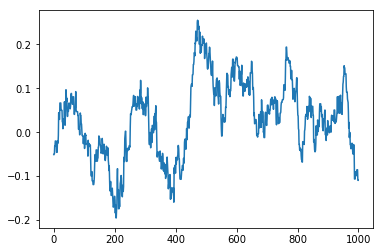

In [9]:
plt.plot((samples - beta_true_scale)[:,3])
plt.show()

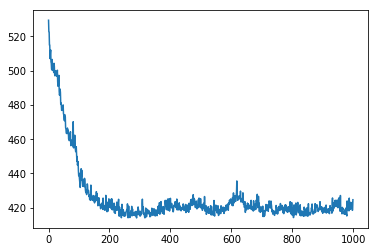

In [10]:
plt.plot(H)
plt.show()

### SGHMC

In [11]:
# HMC - Scaled (no intercept)
nsample = 1000
m = 20
eps = .002
theta = np.zeros(p)
#theta = beta_true_scale.copy()
phi = 5
nbatch = 500
C = 1 * np.identity(p)
V = 0 * np.identity(p)
M = np.identity(p)

samples, H = run_sghmc(Y, Xs, U_logistic, gradU_logistic, M, eps, m, theta, C, V, phi, nsample)

np.mean(samples, axis=0) - beta_true_scale

array([-0.04495083, -0.07772457,  0.02015401, -0.02702875,  0.04350002,
       -0.0195668 , -0.03959012,  0.01211312])

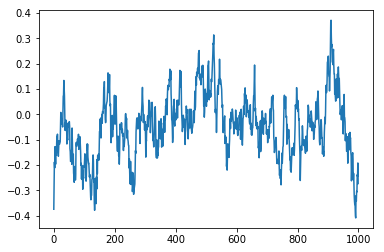

In [12]:
plt.plot((samples - beta_true_scale)[:,0])
plt.show()

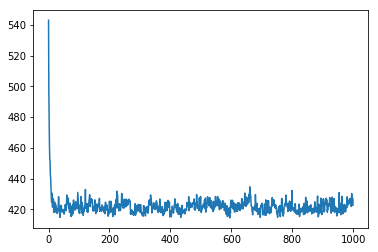

In [13]:
plt.plot(H)
plt.show()

### Gradient Descent

In [249]:
# Gradient descent - Scaled
np.random.seed(2)
phi = .1

res = gd(Y, Xs, gradU, .1, 20000, np.zeros(p), phi)

res - beta_true_scale

array([-0.00056779, -0.001654  ,  0.00055597, -0.00011762,  0.00074642,
       -0.00075326, -0.00043704,  0.00030849])